In [1]:
import pandas as pd
import ccxt
import requests
from datetime import datetime, timedelta

In [2]:
# Aqui definire una funcion para hacer la extraccion de los datos y darle un correcto formato:

def symbol_data(symbol = 'SOLUSDT', timeframe = '1d', since = (datetime.today() - timedelta(days=1000)).strftime('%Y-%m-%d')):
    exchange = ccxt.bybit({'timeout': 100000,'rateLimit': 1200,})
    ts = int(datetime.timestamp(datetime.strptime(since, '%Y-%m-%d'))*1000)
    aux1 = exchange.fetch_ohlcv(symbol = symbol, since = ts, timeframe=timeframe, limit=1000)
    aux2 = pd.DataFrame(aux1, columns=['date', 'open', 'high', 'low','close','volume'])
    aux2['date'] = pd.to_datetime(aux2['date'], unit = 'ms')
    return aux2

In [3]:
# Aqui definire una funcion para saber cual es el sentimiento del mercado en ese momento:

url = 'https://api.alternative.me/fng/'
params = {'limit':1000,
          'format':'json',
          'date_format':'kr'}

request = requests.get(url=url, params=params)
aux1 = request.json()
sentiment = pd.DataFrame(aux1['data'])


In [12]:
symbol = 'ETH/USDT'
data = symbol_data(symbol=symbol)
sentiment = sentiment.iloc[::-1].reset_index(drop=True)

df = pd.concat([data, sentiment], axis=1)
df = df[['date','open',	'high',	'low',	'close', 'volume', 'value',	'value_classification']]

In [13]:
# En este bloque de código importamos los indicadores técnicos que estaremos utilizando:
import numpy as np
from ta.momentum import RSIIndicator as RSI
from ta.trend import MACD, ADXIndicator
from ta.others import DailyReturnIndicator, DailyLogReturnIndicator
from ta.volatility import AverageTrueRange, DonchianChannel
from ta.volume import VolumeWeightedAveragePrice

In [27]:
# Aquí simplemente le agregamos los datos de los indicadores técnicos a nuestro conjunto de datos:

df_ind = df.copy()

df_ind['rsi'] = RSI(df_ind['close']).rsi()
df_ind['macd'] = MACD(df_ind['close']).macd()
df_ind['adx'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx()
df_ind['adp'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_pos()
df_ind['adm'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_neg()
df_ind['dri'] = DailyReturnIndicator(df_ind['close']).daily_return()
df_ind['dlogri'] = DailyLogReturnIndicator(df_ind['close']).daily_log_return()
df_ind['avgtr'] = AverageTrueRange(df_ind['high'], df_ind['low'], df_ind['close']).average_true_range()
df_ind['donch_hband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_hband()
df_ind['donch_lband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_lband()
df_ind['vwap'] = VolumeWeightedAveragePrice(df_ind['high'],df_ind['low'],df_ind['close'], df_ind['volume']).volume_weighted_average_price()

In [33]:
df_ind = df_ind.iloc[26:].reset_index(drop=True)

### Ahora vamos a correr el modelo usando los datos de esta nueva crypto para ver como se desempeña.
### El modelo utilizado fue el que se encuentra en modelos_dummys_ver4.0 y el notebook es volting_classifier_model.ipynb


In [38]:
import os
os.chdir('C:/Users/POZOLE/Documents/pp/nohtyp/practice_algo_trading/modelos_dummys_ver4.0')
from volting_classifier_model import ensemble_clf, scaler # type: ignore

# Supongamos que "df_df_ind" es un DataFrame con la misma estructura que "data" pero sin la columna 'signals'
df_df_ind =df_ind.copy()  # Asegúrate de trabajar sobre una copia

# Seleccionar las columnas de características
features = ['open', 'value', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
            'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']

X_nuevos =df_ind[features]
X_nuevos = X_nuevos.dropna()
# Normalizar usando el mismo scaler que se ajustó en el entrenamiento
X_nuevos_scaled = scaler.transform(X_nuevos)

In [39]:
# Realizar predicciones en los nuevos datos
predicciones = ensemble_clf.predict(X_nuevos_scaled)
df_df_ind = df_df_ind.loc[X_nuevos.index]  # Asegura que coincidan los índices
df_df_ind["predicted_signals"] = predicciones


In [40]:
import numpy as np

# Si 'predicted_signals' está en df_df_ind, haz lo siguiente:
df_df_ind['buy_signal'] = np.where(df_df_ind['predicted_signals'] == 'buy', 1, 0)
df_df_ind['sell_signal'] = np.where(df_df_ind['predicted_signals'] == 'sell', 1, 0)


In [41]:
df_df_ind.head()

,date,open,high,low,close,volume,value,value_classification,rsi,macd,...,adm,dri,dlogri,avgtr,donch_hband,donch_lband,vwap,predicted_signals,buy_signal,sell_signal
0,2022-08-28,1491.06,1510.87,1424.40,1426.93,21983.81013,44,Fear,34.934602,-36.243555,...,29.666982,-4.300967,-4.396199,113.734360,2029.98,1424.40,1667.815342,hold,0,0
1,2022-08-29,1426.93,1560.00,1422.14,1552.09,34780.91304,49,Neutral,44.403569,-38.432253,...,27.138321,8.771278,8.407713,115.457620,2029.98,1422.14,1639.635014,hold,0,0
2,2022-08-30,1552.09,1605.68,1473.61,1524.46,42274.16741,54,Neutral,42.918664,-41.913173,...,24.944773,-1.780180,-1.796216,116.644219,2029.98,1422.14,1616.373007,hold,0,0
3,2022-08-31,1524.46,1620.00,1524.38,1554.70,34392.11381,72,Greed,45.083233,-41.750439,...,23.465900,1.983653,1.964235,115.142489,2029.98,1422.14,1594.756776,hold,0,0
4,2022-09-01,1554.70,1599.94,1513.42,1585.37,28744.88661,44,Fear,47.267338,-38.700542,...,22.876150,1.972728,1.953522,113.098025,2029.98,1422.14,1582.371177,hold,0,0


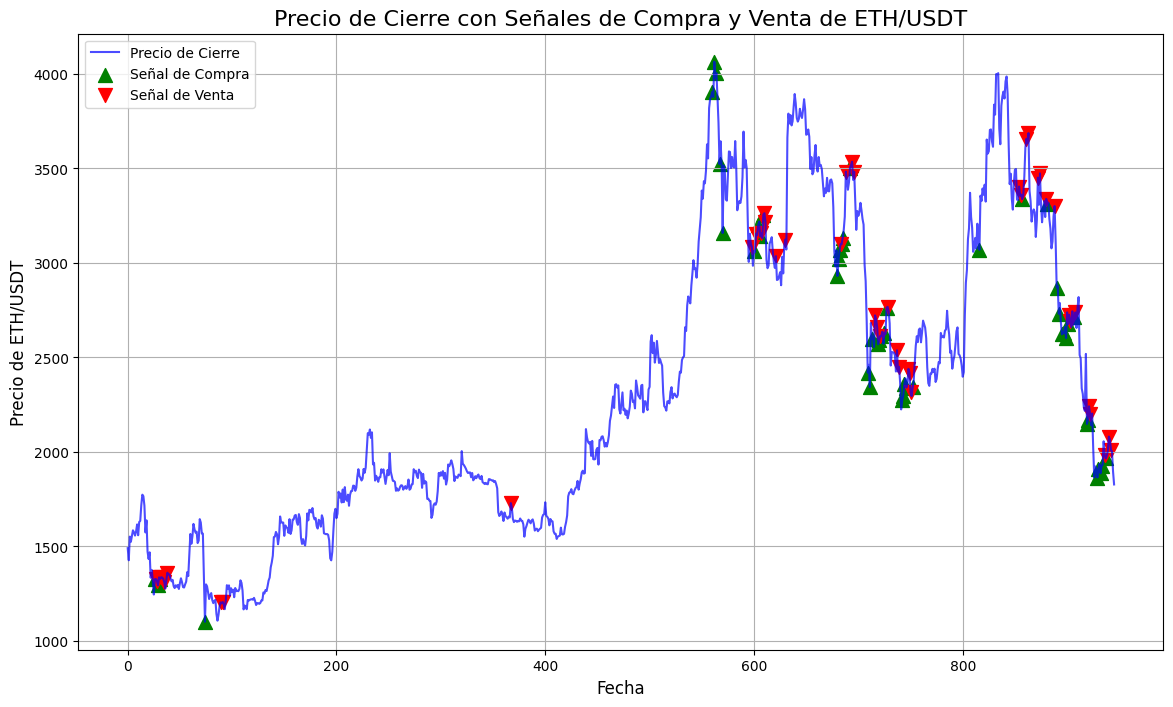

In [42]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df_df_ind.index[df_df_ind['buy_signal'] == 1], df_df_ind['open'][df_df_ind['buy_signal'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df_df_ind.index[df_df_ind['sell_signal'] == 1], df_df_ind['open'][df_df_ind['sell_signal'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title(f'Precio de Cierre con Señales de Compra y Venta de {symbol}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {symbol}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

Compra a 1326.57 en 2022-09-23 00:00:00
Venta a 1327.38 en 2022-09-24 00:00:00 | ROI: 0.06%
Compra a 1294.61 en 2022-09-26 00:00:00
Venta a 1336.39 en 2022-09-27 00:00:00 | ROI: 3.23%
Compra a 1327.9 en 2022-09-28 00:00:00
Venta a 1337.05 en 2022-09-29 00:00:00 | ROI: 0.69%
Compra a 1101.8 en 2022-11-10 00:00:00
Venta a 1203.76 en 2022-11-25 00:00:00 | ROI: 9.25%
Compra a 3905.0 en 2024-03-10 00:00:00
Venta a 3084.0 en 2024-04-17 00:00:00 | ROI: -21.02%
Compra a 3064.39 en 2024-04-19 00:00:00
Venta a 3155.61 en 2024-04-21 00:00:00 | ROI: 2.98%
Compra a 3200.63 en 2024-04-23 00:00:00
Venta a 3156.12 en 2024-04-26 00:00:00 | ROI: -1.39%
Compra a 3255.81 en 2024-04-28 00:00:00
Venta a 3263.46 en 2024-04-29 00:00:00 | ROI: 0.23%
Compra a 2931.07 en 2024-07-08 00:00:00
Venta a 3100.79 en 2024-07-11 00:00:00 | ROI: 5.79%
Compra a 3099.44 en 2024-07-12 00:00:00
Venta a 3483.22 en 2024-07-16 00:00:00 | ROI: 12.38%
Compra a 3504.12 en 2024-07-20 00:00:00
Venta a 3535.96 en 2024-07-22 00:00:00 |

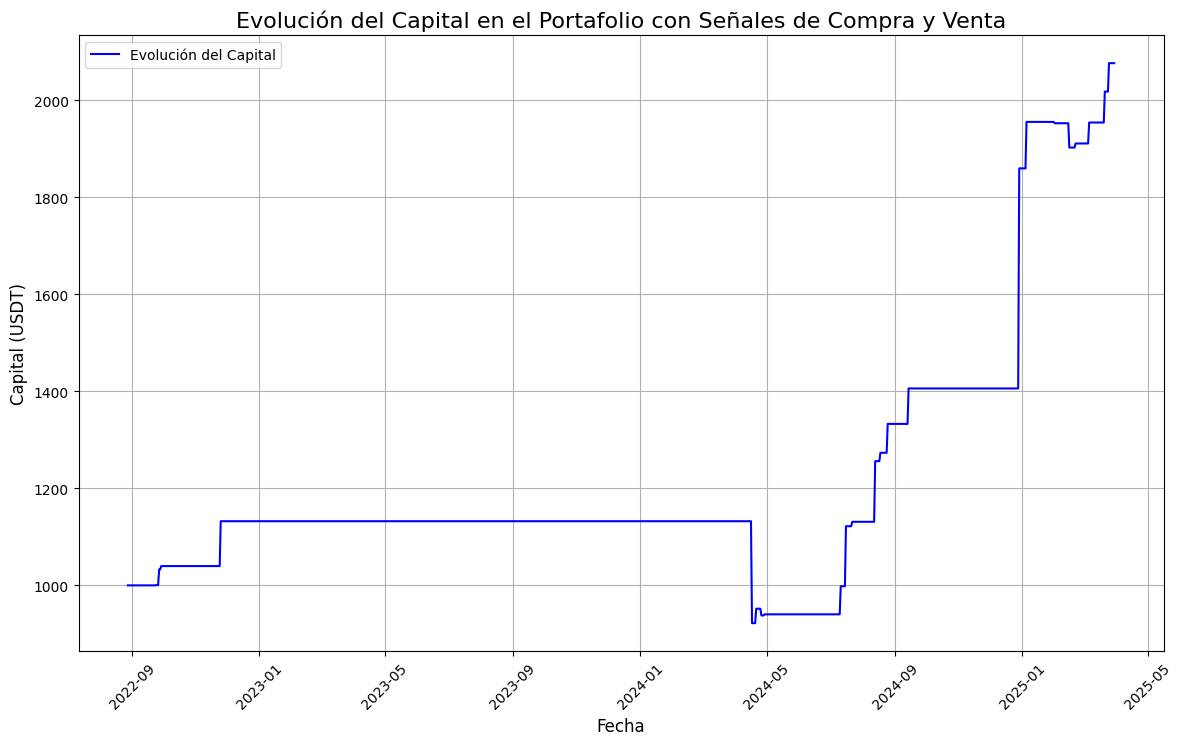

In [43]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open']
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open']
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})

# Graficar la evolución del capital a lo largo del tiempo
plt.figure(figsize=(14, 8))
plt.plot(df_capital['Date'], df_capital['Capital'], label='Evolución del Capital', color='blue')
plt.title('Evolución del Capital en el Portafolio con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital (USDT)', fontsize=12)
plt.grid(True)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()


Capital Final: 3691.35 USDT
Tasa de Retorno Acumulado: 269.14%
Volatilidad Anualizada: 0.5162
Relación de Sharpe: -0.0179
Drawdown Máximo: -25.20%


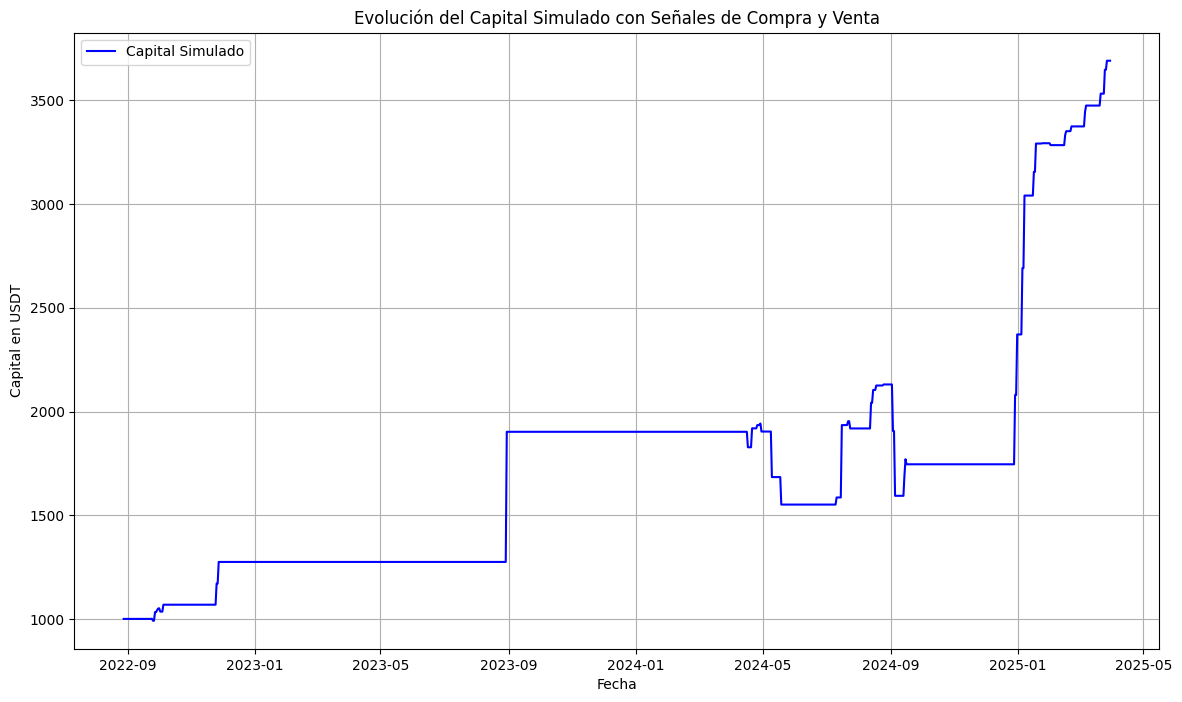

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supongamos que tienes los datos necesarios con las señales predichas
# Aquí se toma el dataframe 'df_df_ind' con las señales de compra y venta predichas

# Asegúrate de que las fechas estén en el formato correcto
df_df_ind['date'] = pd.to_datetime(df_df_ind['date'])
df_df_ind.sort_values('date', inplace=True)

# Calcula el retorno diario en base al precio 'open'
df_df_ind['daily_return'] = df_df_ind['open'].pct_change()

# Calcula el retorno acumulado de la inversión
initial_capital = 1000  # Capital inicial
df_df_ind['capital'] = initial_capital * (1 + df_df_ind['daily_return']).cumprod()

# Simular las compras y ventas
capital = initial_capital
capital_series = []

for i in range(len(df_df_ind)):
    if df_df_ind['buy_signal'].iloc[i]:
        buy_price = df_df_ind['open'].iloc[i]
    if df_df_ind['sell_signal'].iloc[i]:
        sell_price = df_df_ind['open'].iloc[i]
        capital += (sell_price - buy_price)  # Calcular el retorno de la venta
    capital_series.append(capital)

df_df_ind['capital_simulado'] = capital_series

# 1. Calcular el Drawdown
df_df_ind['capital_max'] = df_df_ind['capital_simulado'].cummax()
df_df_ind['drawdown'] = df_df_ind['capital_simulado'] - df_df_ind['capital_max']
df_df_ind['drawdown_pct'] = df_df_ind['drawdown'] / df_df_ind['capital_max'] * 100

# 2. Calcular la volatilidad (desviación estándar de los retornos diarios)
volatilidad = df_df_ind['daily_return'].std() * np.sqrt(252)  # Volatilidad anualizada

# 3. Calcular la rentabilidad diaria promedio
rentabilidad_diaria = df_df_ind['daily_return'].mean()

# 4. Calcular la relación de Sharpe
tasa_libre_riesgo = 0.01  # Asumimos una tasa libre de riesgo del 1%
sharpe_ratio = (rentabilidad_diaria - tasa_libre_riesgo) / volatilidad

# 5. Resultado Final
capital_final = df_df_ind['capital_simulado'].iloc[-1]
tasa_retorno_acumulado = (capital_final - initial_capital) / initial_capital * 100

# Imprimir métricas de desempeño
print(f"Capital Final: {capital_final:.2f} USDT")
print(f"Tasa de Retorno Acumulado: {tasa_retorno_acumulado:.2f}%")
print(f"Volatilidad Anualizada: {volatilidad:.4f}")
print(f"Relación de Sharpe: {sharpe_ratio:.4f}")
print(f"Drawdown Máximo: {df_df_ind['drawdown_pct'].min():.2f}%")

# Graficar la evolución del capital simulado
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['date'], df_df_ind['capital_simulado'], label='Capital Simulado', color='blue')
plt.title('Evolución del Capital Simulado con Señales de Compra y Venta')
plt.xlabel('Fecha')
plt.ylabel('Capital en USDT')
plt.grid(True)
plt.legend()
plt.show()


In [45]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Tarifa de Bybit (comisiones de maker y taker)
maker_fee = 0.0001  # 0.01% en cada compra (maker)
taker_fee = 0.00075  # 0.075% en cada venta (taker)

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open'] * (1 + maker_fee)  # Ajustar por la comisión maker
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price:.2f} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open'] * (1 - taker_fee)  # Ajustar por la comisión taker
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price:.2f} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})


Compra a 1326.70 en 2022-09-23 00:00:00
Venta a 1326.38 en 2022-09-24 00:00:00 | ROI: -0.02%
Compra a 1294.74 en 2022-09-26 00:00:00
Venta a 1335.39 en 2022-09-27 00:00:00 | ROI: 3.14%
Compra a 1328.03 en 2022-09-28 00:00:00
Venta a 1336.05 en 2022-09-29 00:00:00 | ROI: 0.60%
Compra a 1101.91 en 2022-11-10 00:00:00
Venta a 1202.86 en 2022-11-25 00:00:00 | ROI: 9.16%
Compra a 3905.39 en 2024-03-10 00:00:00
Venta a 3081.69 en 2024-04-17 00:00:00 | ROI: -21.09%
Compra a 3064.70 en 2024-04-19 00:00:00
Venta a 3153.24 en 2024-04-21 00:00:00 | ROI: 2.89%
Compra a 3200.95 en 2024-04-23 00:00:00
Venta a 3153.75 en 2024-04-26 00:00:00 | ROI: -1.47%
Compra a 3256.14 en 2024-04-28 00:00:00
Venta a 3261.01 en 2024-04-29 00:00:00 | ROI: 0.15%
Compra a 2931.36 en 2024-07-08 00:00:00
Venta a 3098.46 en 2024-07-11 00:00:00 | ROI: 5.70%
Compra a 3099.75 en 2024-07-12 00:00:00
Venta a 3480.61 en 2024-07-16 00:00:00 | ROI: 12.29%
Compra a 3504.47 en 2024-07-20 00:00:00
Venta a 3533.31 en 2024-07-22 00:00